In [102]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile

In [103]:
import json

with open('recipes_raw_nosource_ar.json') as json_data:
    data_dict = json.load(json_data)
    data_dict = list(data_dict.values())


In [104]:
import json

with open('recipes_raw_nosource_epi.json') as json_data:
    data_dict = json.load(json_data)
    data_dict = list(data_dict.values())


In [105]:
dataset_raw = data_dict

In [106]:
# Filters out recipes which don't have either title or ingredients or instructions.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [107]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 25323
Dataset size AFTER validation 25261
Number of invalide recipes 62


In [108]:
dataset_validated

[{'ingredients': ['12 egg whites',
   '12 egg yolks',
   '1 1/2 cups sugar',
   '3/4 cup rye whiskey',
   '12 egg whites',
   '3/4 cup brandy',
   '1/2 cup rum',
   '1 to 2 cups heavy cream, lightly whipped',
   'Garnish: ground nutmeg'],
  'picture_link': None,
  'instructions': 'Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste.\nBeat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into 

In [109]:
STOP_WORD_TITLE = 'Titre de la recette \n'
STOP_WORD_INGREDIENTS = '\n Liste des ingrédients\n\n'
STOP_WORD_INSTRUCTIONS = '\n Liste des instructions\n\n'

In [110]:
dataset_validated[1]['ingredients']


['18 fresh chestnuts',
 '2 1/2 pounds veal stew meat, cut into 2x1-inch pieces',
 '4 tablespoons olive oil',
 '1 1/2 cups chopped onion',
 '1 1/2 tablespoons chopped garlic',
 '1 bay leaf',
 '2 1/2 cups canned low-salt chicken broth',
 '3/4 cup dry white wine',
 '6 medium carrots, peeled, cut into 1-inch pieces',
 '3 tablespoons chopped fresh sage']

In [111]:
# Converts recipe object to string (sequence of characters) for later usage in RNN input.
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [112]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

In [43]:
dataset_stringified

['Titre de la recette \nChristmas Eggnog \n\n Liste des ingrédients\n\n• 12 egg whites\n• 12 egg yolks\n• 1 1/2 cups sugar\n• 3/4 cup rye whiskey\n• 12 egg whites\n• 3/4 cup brandy\n• 1/2 cup rum\n• 1 to 2 cups heavy cream, lightly whipped\n• Garnish: ground nutmeg\n\n Liste des instructions\n\n▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste.\n▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg

In [113]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:500]):
    print(f'Recette #{recipe_index + 1}\n')
    print(recipe_string)
    print('\n')

Recette #1

Titre de la recette 
Christmas Eggnog 

 Liste des ingrédients

• 12 egg whites
• 12 egg yolks
• 1 1/2 cups sugar
• 3/4 cup rye whiskey
• 12 egg whites
• 3/4 cup brandy
• 1/2 cup rum
• 1 to 2 cups heavy cream, lightly whipped
• Garnish: ground nutmeg

 Liste des instructions

▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste.
▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white m

Recette #273

Titre de la recette 
Buckwheat Banana Cake With Yogurt-Espresso Frosting 

 Liste des ingrédients

• Nonstick vegetable oil spray
• 1 cup whole wheat flour
• 1/2 cup buckwheat flour or whole wheat flour
• 2 teaspoons ground cinnamon
• 1 teaspoon kosher salt
• 1 teaspoon baking soda
• 1/2 teaspoon baking powder
• 4 very ripe bananas
• 2/3 cup (packed) dark brown sugar
• 2 large eggs, beaten to blend
• 1/2 cup olive oil
• 1/2 cup sour cream
• 4 ounces cream cheese, room temperature
• 1/2 cup plain Greek yogurt
• Pinch of kosher salt
• 1/3 cup powdered sugar
• 1/2 teaspoon espresso powder

 Liste des instructions

▪︎ Cake: Preheat oven to 350°F. Coat an 8 1/2x4 1/2" loaf pan with nonstick spray, then line with parchment, letting it hang over on both of the longer sides. Whisk whole wheat flour, buckwheat flour, cinnamon, salt, baking soda, and baking powder in a medium bowl. Mash bananas and brown sugar in a large bowl until virtually no lumps of banana remain and brown suga



Recette #446

Titre de la recette 
Peppermint Patties 

 Liste des ingrédients

• 3 1/4 cups (14 ounces) confectioners' sugar
• 2 tablespoons plus 1 teaspoon water
• 1 tablespoon light corn syrup
• 1 teaspoon fresh lemon juice
• 1/4 teaspoon peppermint extract
• 6 ounces fine-quality bittersweet chocolate (not unsweetened)

 Liste des instructions

▪︎ Sift confectioners' sugar into bowl of a standing electric mixer or a large bowl. In a small bowl stir together water, corn syrup, lemon juice, and extract and add to sugar. With a standing or hand-held electric mixer beat together sugar mixture until combined. On a work surface knead mixture into a ball (mixture will be very stiff). With a rolling pin, applying pressure, roll out mixture between sheets of wax paper into a 9-inch round (about 1/4 inch thick). Remove top sheet of wax paper from round and replace it loosely. Flip over wax paper-enclosed round and remove and discard sheet of wax paper now on top (this process prevents roun

In [114]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

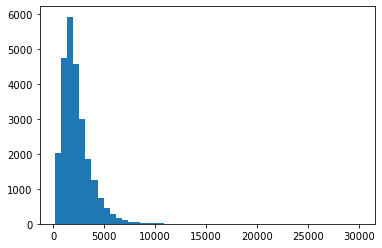

In [115]:
plt.hist(recipes_lengths, bins=50)
plt.show()

In [116]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 2000


In [117]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH

In [118]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]


In [160]:
STOP_SIGN = '.'


In [120]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [161]:
tokenizer.fit_on_texts([STOP_SIGN])


In [122]:
word_index = tokenizer.word_index
word_index

{'␣': 1}

In [123]:
tokenizer.fit_on_texts(dataset_filtered)
word_index = tokenizer.word_index
word_index

{' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'i': 5,
 'n': 6,
 'o': 7,
 's': 8,
 'r': 9,
 'l': 10,
 'd': 11,
 'c': 12,
 'u': 13,
 'h': 14,
 'p': 15,
 'm': 16,
 'g': 17,
 '\n': 18,
 'b': 19,
 '.': 20,
 ',': 21,
 'w': 22,
 'f': 23,
 'v': 24,
 'k': 25,
 '1': 26,
 'y': 27,
 '•': 28,
 '2': 29,
 '/': 30,
 'S': 31,
 '-': 32,
 '▪': 33,
 '︎': 34,
 '4': 35,
 'C': 36,
 '3': 37,
 'L': 38,
 'T': 39,
 'A': 40,
 'x': 41,
 'P': 42,
 '(': 43,
 ')': 44,
 'j': 45,
 '5': 46,
 '0': 47,
 'é': 48,
 ';': 49,
 'z': 50,
 'B': 51,
 'R': 52,
 'F': 53,
 'D': 54,
 'q': 55,
 'M': 56,
 'I': 57,
 'W': 58,
 '6': 59,
 'G': 60,
 '8': 61,
 'H': 62,
 '°': 63,
 'O': 64,
 ':': 65,
 '7': 66,
 'U': 67,
 'E': 68,
 'K': 69,
 "'": 70,
 '9': 71,
 'V': 72,
 '"': 73,
 'J': 74,
 '*': 75,
 '–': 76,
 'N': 77,
 'ñ': 78,
 'è': 79,
 'Y': 80,
 'Q': 81,
 'î': 82,
 'Z': 83,
 '%': 84,
 '—': 85,
 'ç': 86,
 'í': 87,
 '&': 88,
 '’': 89,
 'â': 90,
 '!': 91,
 'X': 92,
 'ó': 93,
 '>': 94,
 'á': 95,
 '+': 96,
 '<': 97,
 'ú': 98,
 'ï': 99,
 '?': 100,
 '$': 1

In [124]:
# Adding +1 to take into account a special unassigned 0 index.
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  160


In [125]:
# For demo application we need to have an array of characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 't', 'a', 'i', 'n', 'o', 's', 'r', 'l', 'd', 'c', 'u', 'h', 'p', 'm', 'g', '\n', 'b', '.', ',', 'w', 'f', 'v', 'k', '1', 'y', '•', '2', '/', 'S', '-', '▪', '︎', '4', 'C', '3', 'L', 'T', 'A', 'x', 'P', '(', ')', 'j', '5', '0', 'é', ';', 'z', 'B', 'R', 'F', 'D', 'q', 'M', 'I', 'W', '6', 'G', '8', 'H', '°', 'O', ':', '7', 'U', 'E', 'K', "'", '9', 'V', '"', 'J', '*', '–', 'N', 'ñ', 'è', 'Y', 'Q', 'î', 'Z', '%', '—', 'ç', 'í', '&', '’', 'â', '!', 'X', 'ó', '>', 'á', '+', '<', 'ú', 'ï', '?', '$', 'û', '=', 'ü', 'ê', '½', 'à', '�', '_', '‚', 'º', '\xad', ']', 'ä', '[', '¼', '́', '⁄', 'ö', '#', 'ô', 'ì', '˚', '»', '\x96', 'ù', '◊', '×', '‱', '“', '”', '‧', '\u202d', '¾', '⅛', 'å', 'ﬂ', '§', '\x97', '\x1a', 'ø', '¿', '⅓', '{', '}', 'ư', '´', '␣', 'Á', '|', '¤', '\xa0', 'ơ', 'ă', '̀', '`', '⅞', '\x92', 'ë']


In [126]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [127]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)


In [128]:
print(dataset_vectorized[0][:10], '...')

[39, 5, 3, 9, 2, 1, 11, 2, 1, 10] ...


In [129]:
recipe_sequence_to_string(dataset_vectorized[0])


Titre de la recette 
Christmas Eggnog 

 Liste des ingrédients

• 12 egg whites
• 12 egg yolks
• 1 1/2 cups sugar
• 3/4 cup rye whiskey
• 12 egg whites
• 3/4 cup brandy
• 1/2 cup rum
• 1 to 2 cups heavy cream, lightly whipped
• Garnish: ground nutmeg

 Liste des instructions

▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste.
▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into 

In [143]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 1259
Recipe #2 length: 884
Recipe #3 length: 1615
Recipe #4 length: 1681
Recipe #5 length: 1167
Recipe #6 length: 978
Recipe #7 length: 594
Recipe #8 length: 1729
Recipe #9 length: 1316
Recipe #10 length: 380


In [162]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [163]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [164]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [165]:
recipe_sequence_to_string(dataset_vectorized_padded[3])


Titre de la recette 
White Sauce or Bechamel Sauce 

 Liste des ingrédients

• 2 tablespoons butter
• 2 tablespoons flour
• 1 1/4 cups milk, heated
• Salt
• Freshly ground pepper

 Liste des instructions

▪︎ Melt the butter in a heavy-bottomed saucepan. Stir in the flour and cook, stirring constantly, until the paste cooks and bubbles a bit, but don't let it brown — about 2 minutes. Add the hot milk, continuing to stir as the sauce thickens. Bring it to a boil. Add salt and pepper to taste, lower the heat, and cook, stirring for 2 to 3 minutes more. Remove from the heat. To cool this sauce for later use, cover it with wax paper or pour a film of milk over it to prevent a skin from forming.
▪︎ Melt the butter in a heavy-bottomed saucepan. Stir in the flour and cook, stirring constantly, until the paste cooks and bubbles a bit, but don't let it brown — about 2 minutes. Add the hot milk, continuing to stir as the sauce thickens. Bring it to a boil. Add salt and pepper to taste, lower the 

In [166]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (2001,), types: tf.int32>


In [167]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [39  5  3 ... 20 20 20] 



Stringified recipe:

Titre de la recette 
Christmas Eggnog 

 Liste des ingrédients

• 12 egg whites
• 12 egg yolks
• 1 1/2 cups sugar
• 3/4 cup rye whiskey
• 12 egg whites
• 3/4 cup brandy
• 1/2 cup rum
• 1 to 2 cups heavy cream, lightly whipped
• Garnish: ground nutmeg

 Liste des instructions

▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste.
▪︎ Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and sti

In [168]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [169]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [170]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   'T i t r e   d e   l a   r e c e t t e   \n C h r i s t m a s   E g g n o g   \n \n   L i s t e   d e s'
Target:  'i t r e   d e   l a   r e c e t t e   \n C h r i s t m a s   E g g n o g   \n \n   L i s t e   d e s  '


In [171]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 39 ('T')
  expected output: 5 ('i')
Step  2
  input: 5 ('i')
  expected output: 3 ('t')
Step  3
  input: 3 ('t')
  expected output: 9 ('r')
Step  4
  input: 9 ('r')
  expected output: 2 ('e')
Step  5
  input: 2 ('e')
  expected output: 1 (' ')
Step  6
  input: 1 (' ')
  expected output: 11 ('d')
Step  7
  input: 11 ('d')
  expected output: 2 ('e')
Step  8
  input: 2 ('e')
  expected output: 1 (' ')
Step  9
  input: 1 (' ')
  expected output: 10 ('l')
Step 10
  input: 10 ('l')
  expected output: 4 ('a')


In [173]:
import json
from pprint import pprint

In [184]:
with open('full_format_recipes.json', encoding='utf-8') as f: 
    data = json.load(f)
    with open("input.txt", "w",encoding='utf-8') as file: 
        for i in range(8000) : 
            if 'title' in data[i] : 
                file.write('\n' + 'Title: ' + data[i]['title'] + '\n')
                file.write('\n' + 'Ingredients:'+ '\n')
                file.write('\n'.join(data[i]['ingredients']) + '\n')
                file.write('\n' + 'Directions:' + '\n')
                file.write('\n'.join(data[i]['directions']) + '\n \n')



In [185]:
data

[{'directions': ['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.',
   '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.',
   '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.'],
  'fat': 7.0,
  'date': '2006-09-01T04:00:00.000Z',
  'categories': ['Sandwich',
   'Bean',
   'Fruit',
   'Tomato',
  